**HW_2**

Добрый день(вечер или даже утро) дорогой проверяющий, надеюсь я достаточно аккуратно изьясню свои мысли, чтобы вам было приятно читать данный jupyter notebook.

Данное домашнее задание состоит из двух jupyter notebooks:

1) HW2: Profile & optimise PairwiseCounter_profile.ipynb - (профилирование изначально полученного "плохого" кода с помощью line_profiler, memory_profiler и поиск "узких" мест с помощью инстурментов, описаннных ранее.)

2) HW2: Profile & optimise PairwiseCounter_optimaze.ipynb - (Предпринятые шаги по улучшению скорости работы кода без "взрывного" увеличения используемой памяти).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова

/content/drive/MyDrive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова


In [ ]:
ls -la

total 72471
-rw------- 1 root root     1718 Apr 18 17:09  find_and_write_most_to_ocurring_product_in_file_opt_2.py
-rw------- 1 root root      839 Apr 18 17:09  find_and_write_most_to_ocurring_product_in_file_opt_2.py.lprof
-rw------- 1 root root     1377 Apr 18 16:52  find_and_write_most_to_ocurring_product_in_file_opt.py
-rw------- 1 root root      784 Apr 18 16:53  find_and_write_most_to_ocurring_product_in_file_opt.py.lprof
-rw------- 1 root root     1416 Apr 18 16:02  find_and_write_most_to_ocurring_product_in_file.py
-rw------- 1 root root      974 Apr 18 16:02  find_and_write_most_to_ocurring_product_in_file.py.lprof
-rw------- 1 root root    50924 Apr 18 11:56 'HW2: Profile & optimise PairwiseCounter.ipynb'
-r-------- 1 root root   241051 Apr 18 17:45 'HW2: Profile & optimise PairwiseCounter_optimaze.ipynb'
-r-------- 1 root root    35916 Apr 18 17:44 'HW2: Profile & optimise PairwiseCounter_profile.ipynb'
-rw------- 1 root root      691 Apr 18 16:52  load_data_and_create_list_

In [ ]:
!pip install line_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 4

     |████████████████████████████████| 71kB 4.7MB/s 


In [ ]:
!pip install memory_profiler
%load_ext memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=467100cb4757c5e6fe4772fc22476236007c3c3378a81c6611388156d1a3d8ca
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


# Шаг 1
(Настоятельно рекомендую всё таки бегло просмотреть ноутбук с профилированием исходного кода и выводами, следующими после профилирования. В идеале воспользоваться 2-мя мониторами и получать удовольствие от прочтения.)

### Воспользуемся выводами с профилирования исходного кода:

5) get_stats(Total time: 1.68843 s) - как видно из профайлера, проблема связана с тем, что очень много времени тратиться при обращении к конкретным элементам разреженной матрицы, поэтому это пока первостепенная проблема, с которой мы попытаемся разобраться.

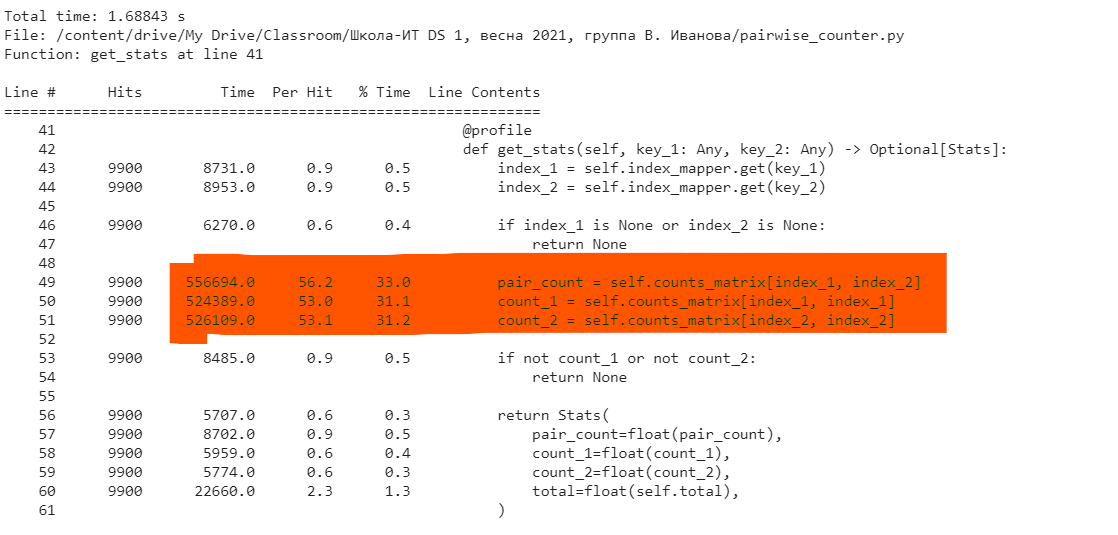

Очевидно, что мы почти всегда(2/3) обращаемся к диагональным элементам матрицы, следовательно лучше сразу создать список nd.array диагональных элементов и обращаться уже к нему.(См. реализацияю ниже.)

In [ ]:
%%writefile pairwise_counter_opt.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple
 
import numpy as np
 
from scipy import sparse
 

EPS = 1e-100
 
 
class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float
 
 
class PairwiseCounter:

    @profile
    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.diagonal_elems_of_count_matrix = counts_matrix.diagonal() # diagonal elements of scipy.sparse.csr_matrix 
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = self.counts_matrix[total_index, total_index]

    @profile
    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)
 
        if index_1 is None or index_2 is None:
            return None
 
        pair_count = self.counts_matrix[index_1, index_2]
        count_1 = self.diagonal_elems_of_count_matrix[index_1] # take first diagonal element
        count_2 = self.diagonal_elems_of_count_matrix[index_2] # take second diagonal element
 
        if not count_1 or not count_2:
            return None
 
        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1),
            count_2=float(count_2),
            total=float(self.total),
        )

    @profile
    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """
 
        stats = self.get_stats(key_1, key_2)
        if stats is None:
            return None
        return (
            np.log(stats.pair_count + EPS)
            + np.log(stats.total)
            - np.log(stats.count_1)
            - np.log(stats.count_2)
        )
 
    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )
 
    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )

Overwriting pairwise_counter_opt.py


Остальная часть пока без изменений

In [ ]:
%%writefile load_data_and_create_list_of_product_ids_opt.py

import collections
import json
import typing as tp

from tqdm.auto import tqdm

from pairwise_counter_opt import PairwiseCounter


def load_data():
    with open('product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
        pairwise_counter = PairwiseCounter.from_dict(json.load(infile))
    return pairwise_counter


def create_list_of_product_ids(pairwise_counter):
    product_ids = [
        product_id 
        for product_id in pairwise_counter.index_mapper.keys() 
        if product_id != pairwise_counter.total_key
    ]
    return product_ids


if __name__ == "__main__":
    pairwise_counter = load_data()
    product_ids = create_list_of_product_ids(pairwise_counter)

Writing load_data_and_create_list_of_product_ids_opt.py


In [ ]:
%%writefile find_and_write_most_to_ocurring_product_in_file_opt.py

import collections
import json
import typing as tp


from load_data_and_create_list_of_product_ids_opt import load_data, create_list_of_product_ids
from pairwise_counter_opt import PairwiseCounter


@profile
def find_and_write_most_to_ocurring_product_in_file(product_ids, pairwise_counter):
    MAX_TOP_CANDIDATES: int = 10
    most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()
    
    for key_1 in product_ids[:100]: 
        candidates: tp.List[tp.Tuple[str, float]] = []
        for key_2 in product_ids[:100]: 
            if key_1 == key_2:
                continue
    
            pmi = pairwise_counter.calculate_pmi(key_1, key_2)
            if pmi is None:
                continue
    
            candidates.append((key_2, pmi))
    
        top_candidates = sorted(
            candidates, 
            key=lambda p: p[1], 
            reverse=True
        )[:MAX_TOP_CANDIDATES]
        most_co_occurring_products[key_1] = [
            product_id
            for product_id, pmi in top_candidates
        ]    

    with open('most_co_occurring_products_opt.txt', 'w') as outfile:
        json.dump(most_co_occurring_products, outfile)


if __name__ == "__main__":
    pairwise_counter = load_data()
    product_ids = create_list_of_product_ids(pairwise_counter)
    find_and_write_most_to_ocurring_product_in_file(product_ids, pairwise_counter)

Writing find_and_write_most_to_ocurring_product_in_file_opt.py


In [ ]:
!kernprof -l -v find_and_write_most_to_ocurring_product_in_file_opt.py

Wrote profile results to find_and_write_most_to_ocurring_product_in_file_opt.py.lprof
Timer unit: 1e-06 s

Total time: 0.006373 s
File: /content/drive/My Drive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt.py
Function: __init__ at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                               @profile
    21                                               def __init__(
    22                                                       self,
    23                                                       counts_matrix: sparse.csr_matrix,
    24                                                       index_mapper: Dict[Any, int],
    25                                                       total_key: Any,
    26                                               ):
    27                                                   """
    28                                                   Class for calculating some pair st

In [ ]:
!python -m memory_profiler find_and_write_most_to_ocurring_product_in_file_opt.py

Filename: /content/drive/My Drive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt.py

Line #    Mem usage    Increment  Occurences   Line Contents
    20  549.316 MiB  549.316 MiB           1       @profile
    21                                             def __init__(
    22                                                     self,
    23                                                     counts_matrix: sparse.csr_matrix,
    24                                                     index_mapper: Dict[Any, int],
    25                                                     total_key: Any,
    26                                             ):
    27                                                 """
    28                                                 Class for calculating some pair statistics.
    29                                                 :param counts_matrix: sparse matrix of pairs
    30                                                 :param inde

## Выводы после 1-ого шага
1)get_stats(Total time: 0.666549 s) - как видим, идея с созданием отдельного списка nd.array диагональных элементов неплохо снизила(более чем в 2 раза) время работы ф-ии get_stats при обращении к 3-м элементам разреженной матрицы(Также как видно по memory_profile не возникает огромного дополнительного потребления памяти, что впринципе логично).


# Шаг 2

Опять же обращаемся к выводам при профилировании исходного кода:

3) find_and_write_most_to_ocurring_product_in_file(Total time: 2.00509 s) - очевидная проблематика долгой работы данной функции кроется в ф-ии -> calculate_pmi.

Если проблему не оптимальной работы ф-ии calculate_pmi мы постарались устранить, то по прежнему остро стоит вопрос о том, что данная ф-я вызывается n ** 2 - n, хотя это переизбыточно....
Матрица статистики PMI является СИММЕТРИЧНОЙ(Это и очевидно, и упоминается при первом же обращении к любому источнику информации по данной тематике). 

Обратимся к профилированию на предыдущем шаге:
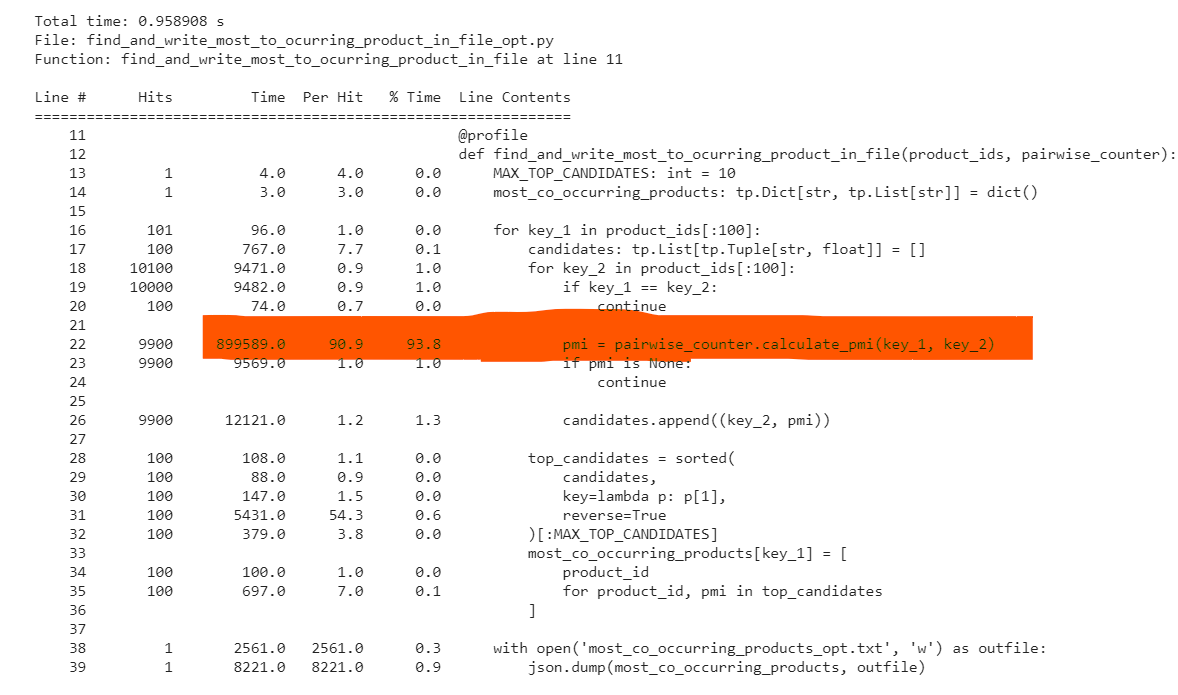

Как видно, операция подсчёта статистики PMI занимат очень много времени, поэтому перепишем код так, чтобы в силу симметричности матрицы учитывать статистики, которые были посчитаны ранее(См. код ниже).

In [ ]:
%%writefile find_and_write_most_to_ocurring_product_in_file_opt_2.py

import collections
import json
import typing as tp


from load_data_and_create_list_of_product_ids_opt import load_data, create_list_of_product_ids
from pairwise_counter_opt import PairwiseCounter


@profile
def find_and_write_most_to_ocurring_product_in_file_2(product_ids, pairwise_counter, N=100):
    MAX_TOP_CANDIDATES: int = 10
    most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()
    
    for i in range(N): 
        key_1 = product_ids[i]
        candidates: tp.List[tp.Tuple[str, float]] = []
        
        for j in range(N):
            key_2 = product_ids[j]

            if i == j:
                continue
            if i < j:
                pmi = pairwise_counter.calculate_pmi(key_1, key_2)
            elif i > j:
                pmi = most_co_occurring_products[key_2][i-1][1]
            candidates.append((key_2, pmi))

        most_co_occurring_products[key_1] = candidates
    
    for key_i in most_co_occurring_products:
        top_candidates = sorted(
                            [elem for elem in most_co_occurring_products[key_i] if elem[1] is not None],
                            key=lambda elem: elem[1], 
                            reverse=True
                          )[:MAX_TOP_CANDIDATES]

        most_co_occurring_products[key_i] = [
            product_id
            for product_id, pmi in top_candidates
        ]    

    with open('most_co_occurring_products_opt.txt', 'w') as outfile:
        json.dump(most_co_occurring_products, outfile)


if __name__ == "__main__":
    pairwise_counter = load_data()
    product_ids = create_list_of_product_ids(pairwise_counter)
    find_and_write_most_to_ocurring_product_in_file_2(product_ids, pairwise_counter)

Writing find_and_write_most_to_ocurring_product_in_file_opt_2.py


In [ ]:
!kernprof -l -v find_and_write_most_to_ocurring_product_in_file_opt_2.py

Wrote profile results to find_and_write_most_to_ocurring_product_in_file_opt_2.py.lprof
Timer unit: 1e-06 s

Total time: 0.006295 s
File: /content/drive/My Drive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt.py
Function: __init__ at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                               @profile
    21                                               def __init__(
    22                                                       self,
    23                                                       counts_matrix: sparse.csr_matrix,
    24                                                       index_mapper: Dict[Any, int],
    25                                                       total_key: Any,
    26                                               ):
    27                                                   """
    28                                                   Class for calculating some pair 

In [ ]:
!python -m memory_profiler find_and_write_most_to_ocurring_product_in_file_opt_2.py

Filename: /content/drive/My Drive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt.py

Line #    Mem usage    Increment  Occurences   Line Contents
    20  549.074 MiB  549.074 MiB           1       @profile
    21                                             def __init__(
    22                                                     self,
    23                                                     counts_matrix: sparse.csr_matrix,
    24                                                     index_mapper: Dict[Any, int],
    25                                                     total_key: Any,
    26                                             ):
    27                                                 """
    28                                                 Class for calculating some pair statistics.
    29                                                 :param counts_matrix: sparse matrix of pairs
    30                                                 :param inde

# Выводы после 2-ого шага

Изменения не повлекли за собой взрыва использования памяти...(и это прекрасно), но самое главное мы ещё более сократили затрачиваемое программой время.

Было: (Total time: 2.00509 s
File: find_and_write_most_to_ocurring_product_in_file.py)

Стало: (Total time: 0.509989 s
File: find_and_write_most_to_ocurring_product_in_file_opt_2.py)

На данном этапе получили неплохое ускорение работы программы без особого рефакторинга кода.(Я решил остановиться на данном этапе)

# Шаг 3

На основе ревью кода, было предложено полностью заменить разреженную матрицу
на словарь(так как обращение к элементам разреженной матрицы - долгая операция).

Но избавляться от функционала разреженных матриц я не буду, так как данный функционал может использоваться во внешнем коде. 

Также немного изменим load_data т.к теперь используем from_dict_wrapper

In [ ]:
%%writefile pairwise_counter_opt_v3.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple
 
import numpy as np
 
from scipy import sparse
 

EPS = 1e-100
 
 
class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float
 
 
class PairwiseCounter:

    @profile
    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = self.counts_matrix[total_index, total_index]

    @profile
    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)
 
        if index_1 is None or index_2 is None:
            return None

        pair_count = self.counts_matrix_dict.get((index_1, index_2), 0) # use dict instead of scipy.sparse.csr_matrix 
        count_1 = self.diagonal_elems_of_count_matrix[index_1] # take first diagonal element
        count_2 = self.diagonal_elems_of_count_matrix[index_2] # take second diagonal element
 
        if not count_1 or not count_2:
            return None
 
        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1),
            count_2=float(count_2),
            total=float(self.total),
        )

    @profile
    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """
 
        stats = self.get_stats(key_1, key_2)
        if stats is None:
            return None
        return (
            np.log(stats.pair_count + EPS)
            + np.log(stats.total)
            - np.log(stats.count_1)
            - np.log(stats.count_2)
        )
 
    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )
 
    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )

    @staticmethod
    def from_dict_wrapper(params_dict: Dict[str, Any]):
        """
        To Do
        """

        diagonal_elements_of_counts_matrix = []
        counts_matrix_dict = {}

        shape = params_dict['counts_matrix']['shape']
        data = params_dict['counts_matrix']['data']
        indices = params_dict['counts_matrix']['indices']
        indptr = params_dict['counts_matrix']['indptr']

        for i in range(shape[0]):
            indptr_i = indptr[i]
            indptr_i_1 = indptr[i+1]
            for j, data_ij in zip(indices[indptr_i: indptr_i_1], data[indptr_i: indptr_i_1]):
                counts_matrix_dict[(i, j)] = data_ij
            
            diagonal_elements_of_counts_matrix.append(counts_matrix_dict.get((i, i), 0))
        
        diagonal_elements_of_counts_matrix = np.array(diagonal_elements_of_counts_matrix)

        pairwise_counter = PairwiseCounter.from_dict(params_dict)
        pairwise_counter.diagonal_elems_of_count_matrix = diagonal_elements_of_counts_matrix
        pairwise_counter.counts_matrix_dict = counts_matrix_dict

        return pairwise_counter

Overwriting pairwise_counter_opt_v3.py


In [ ]:
%%writefile load_data_and_create_list_of_product_ids_opt_v3.py

import collections
import json
import typing as tp

from tqdm.auto import tqdm

from pairwise_counter_opt_v3 import PairwiseCounter


def load_data():
    with open('product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
        pairwise_counter = PairwiseCounter.from_dict_wrapper(json.load(infile)) # use from_dict_wrapper instead of from_dict
    return pairwise_counter


def create_list_of_product_ids(pairwise_counter):
    product_ids = [
        product_id 
        for product_id in pairwise_counter.index_mapper.keys() 
        if product_id != pairwise_counter.total_key
    ]
    return product_ids


if __name__ == "__main__":
    pairwise_counter = load_data()
    product_ids = create_list_of_product_ids(pairwise_counter)

Writing load_data_and_create_list_of_product_ids_opt_v3.py


In [ ]:
%%writefile find_and_write_most_to_ocurring_product_in_file_opt_v3.py

import collections
import json
import typing as tp


from load_data_and_create_list_of_product_ids_opt_v3 import load_data, create_list_of_product_ids
from pairwise_counter_opt_v3 import PairwiseCounter


@profile
def find_and_write_most_to_ocurring_product_in_file_2(product_ids, pairwise_counter, N=100):
    MAX_TOP_CANDIDATES: int = 10
    most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()
    
    for i in range(N): 
        key_1 = product_ids[i]
        candidates: tp.List[tp.Tuple[str, float]] = []
        
        for j in range(N):
            key_2 = product_ids[j]

            if i == j:
                continue
            if i < j:
                pmi = pairwise_counter.calculate_pmi(key_1, key_2)
            elif i > j:
                pmi = most_co_occurring_products[key_2][i-1][1]
            candidates.append((key_2, pmi))

        most_co_occurring_products[key_1] = candidates
    
    for key_i in most_co_occurring_products:
        top_candidates = sorted(
                            [elem for elem in most_co_occurring_products[key_i] if elem[1] is not None],
                            key=lambda elem: elem[1], 
                            reverse=True
                          )[:MAX_TOP_CANDIDATES]

        most_co_occurring_products[key_i] = [
            product_id
            for product_id, pmi in top_candidates
        ]    

    with open('most_co_occurring_products_opt.txt', 'w') as outfile:
        json.dump(most_co_occurring_products, outfile)


if __name__ == "__main__":
    pairwise_counter = load_data()
    product_ids = create_list_of_product_ids(pairwise_counter)
    find_and_write_most_to_ocurring_product_in_file_2(product_ids, pairwise_counter)

Writing find_and_write_most_to_ocurring_product_in_file_opt_v3.py


In [ ]:
!kernprof -l -v find_and_write_most_to_ocurring_product_in_file_opt_v3.py

Wrote profile results to find_and_write_most_to_ocurring_product_in_file_opt_v3.py.lprof
Timer unit: 1e-06 s

Total time: 0.00023 s
File: /content/drive/My Drive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt_v3.py
Function: __init__ at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                               @profile
    21                                               def __init__(
    22                                                       self,
    23                                                       counts_matrix: sparse.csr_matrix,
    24                                                       index_mapper: Dict[Any, int],
    25                                                       total_key: Any,
    26                                               ):
    27                                                   """
    28                                                   Class for calculating some pa

In [ ]:
!python -m memory_profiler find_and_write_most_to_ocurring_product_in_file_opt_v3.py

Filename: /content/drive/MyDrive/Classroom/Школа-ИТ DS 1, весна 2021, группа В. Иванова/pairwise_counter_opt_v3.py

Line #    Mem usage    Increment  Occurences   Line Contents
    20 1715.141 MiB 1715.141 MiB           1       @profile
    21                                             def __init__(
    22                                                     self,
    23                                                     counts_matrix: sparse.csr_matrix,
    24                                                     index_mapper: Dict[Any, int],
    25                                                     total_key: Any,
    26                                             ):
    27                                                 """
    28                                                 Class for calculating some pair statistics.
    29                                                 :param counts_matrix: sparse matrix of pairs
    30                                                 :param in

# Выводы после 3-ого шага

Изменения повлекли за собой увеличение используемой памяти примерно в 5 раз(что было предсказуемо, так как словарь всё таки не дешёвая структура данных)

Было: (Total time: 2.00509 s
File: find_and_write_most_to_ocurring_product_in_file.py)

Было(2ой шаг оптимизации): (Total time: 0.509989 s
File: find_and_write_most_to_ocurring_product_in_file_opt_2.py)

Стало(3ий шаг оптимизации): Total time: 0.223504 s
File: find_and_write_most_to_ocurring_product_in_file_opt_v3.py 

Создание словаря и использование его вместо разреженной матрицы для обращения к конкретным элементам, а также вынесение диагональных элементов матрицы привело нас к заметному ускорению исполнения кода(но повлекло за собой определенное увеличение кол-ва используемой памяти).